# Recipe Recommender Capstone Project

** Task: ** Given a recipe from the existing data set that you have, suggest another recipe by replacing n (random) ingredients. The new recipe should:
- “make sense” according to certain standards of taste
- not be a subset of ingredients of an existing recipe in the dataset

## Data Cleaning

The data has been scrapped from http://allrecipes.com/. It consists of over 7K recipes and 2.5M reviews.

In [1]:
import json
import numpy as np
from numpy import ma
import io
import re
import itertools
import random
from bokeh.charts import Histogram
import networkx as nx

from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
from sklearn.feature_extraction import DictVectorizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import NumeralTickFormatter,ColumnDataSource, LabelSet
output_notebook()
import copy
%matplotlib inline

Loading BokehJS ...

In [2]:
def get_matrix_form(ingredients_list):
    """
    Converts list of ingredients to sparse matrix form
    Args:
        ingredients_list: list of ingredients lists 
    """
    vec = DictVectorizer()
    X = vec.fit_transform([Counter(x) for x in ingredients_list]) 
    return X.toarray(),np.array(vec.get_feature_names()) 

### Removing the Unrelated Words from Ingredients

1. Quantifiers and descriptive words are filtered out from the ingredients.  
2. Each word is lemmatized

In [3]:
#filter out the words that are not ingredients
unrelated = ["","a","an",'teaspoon','oz','cup','tablespoon','gram','kilogram','kg','pound',
             'milliliter','ml','envelope','substitute','chip',
             'ounce','tsp','tbl','tb','tbsp','pint','pt','lb','liter','fluid',"halves","inch",
             "skinless", "boneless","pounded","thickness","thick","cooking","cubed","instant",
             "to","from","unsalted","pinch","chopped",'fresh', 'flat', 'leaf',"packages",
             "minced","cloves","pinched","sliced","tablespoons","taste","all","purpose",
             'teaspoons', 'beaten', 'cups', 'for', 'frying', 'or', 'as', 'needed' ,"ground",
             "large","small","big","cut","half","finely","peeled","cooked","lightly",
             "in","and","or","kosher","halal","ounces","ounces","can","freshly","crushed","dried",
             "slices","slice","diced",'into', 'cubes','divided',"melted","frozen","deveined",
             "optional","cans","canned","grated","pounds","lean","packed","mashed","overripe",
             'quarters', 'vertically','package','tops', 'removed', 'seeded','softened','extra',
             "bottle","condensed","of","style","heavy","torn","piece","shredded","pieces",
             "stewed","chunks","chunk","mix","whole","clove","light","assorted","s","with",
             "food","jar","spray","toasted",'favorite', 'chop','bite',
             'chuck','chop','cleaned','container','covered','degree','delicious','double',
             'medium','prepared',
             'preserve','quick','refrigerated','rinsed','roast','rolled','room','stew',
             'temperature','plus','packet','pack',
             'trimmed','unwrapped','warm','flavored','link','sized','bulk','low',
             'high','sifted','','square','thinly','drained','halved',
             'cube','concentrate','crumb','crumbled','warmed','partially',
             'portion','dissolved','halve','skinned','thin','deboned','boiled',
             'butterflied','cooled','more','defrosted','size','quartered'
            ]

def is_numeric(c):
    """
    Check if a given string is numeric or alphanumeric
    Args:
        c (str): string to check
    Returns: 
        True if the given parameter is numeric
    """
    try:
        float(c)
    except ValueError:
        return False
    else:
        return True 
    
def clean_ingredients(ingredients):
    """
    Filters the words that are not an ingredient but are in the ingredient specifications
    Args:
        ing (str): a line from ingredient list
    Returns:
        ingredient string: if it is considered as an ingredient 
        False: if the given ingredient is filtered as a non-ingredient
    """
    ingredients = list(map(str.lower,re.split("\W+",ingredients)))
    return [wnl.lemmatize(ingredient.strip()) for ingredient in ingredients if not (len(ingredient) <1 or ingredient in unrelated or is_numeric(ingredient))]


In [4]:
#read the recipes
all_ingredients = []
recipe_dic = dict()
reviews_dic = dict()
names = []
with open("data/recipes.data","r") as f:

    for line in f:
        recipe  = json.load(io.StringIO(line))
        name = recipe['name']
        num_rating = recipe['num_ratings']
        categories = recipe['categories']
        rid = recipe['id']
        rating = recipe['rating']
        cleaned_ingredients = [clean_ingredients(_ingredients) for _ingredients in recipe['ingredients'] ]
        ingredients_filtered = [_ingredient for _ingredient in cleaned_ingredients if len(_ingredient) < 4]
        #print (" id: ",rid,"\n Rating: ",rating,"\n #Ratings: ",num_rating,"\n Name: ",name,"\n Categories: ",categories,"\n Ingredients: ",ingredients,"\n\n")
        if ingredients_filtered and len(ingredients_filtered) > 0:
            recipe_dic[name] = list(set([" ".join(x) for x in ingredients_filtered]))#ingredients_filtered
            reviews_dic[name] = rating


## Ingredient Analysis

Total number of recipes:

In [5]:
len(recipe_dic.values())

6171

In [6]:
#flatten the ingredients of each recipe for vectorization
all_ingredients = [ingredient for ingredient in recipe_dic.values()]

In [7]:
ingredient_matrix,vocabulary = get_matrix_form(all_ingredients)
word_counts = ingredient_matrix.sum(axis=0)
sorted_indicies = np.argsort(word_counts)[::-1]
word_counts = np.array(list(map(lambda x: int(x),word_counts)))

Number of unique ingredients:

In [8]:
ingredient_matrix.shape[1]

2951

Find out which ingredients are most frequently used in the recipes

In [9]:
ingredient_frequency = list(zip(vocabulary[sorted_indicies],word_counts[sorted_indicies]))[:1000]
#sorted(vec.vocabulary_)

In [10]:
#divide number of occurance of each ingredient to the total number of recipes 
popular_ingredients = list(map(lambda x: ( x[0],float( "{0:.2f}".format(x[1] / len(recipe_dic.values())) ) ), ingredient_frequency[:30]))

In [11]:
#separate the ingredient names and frequencies for plotting
ings = list(map(lambda x: x[0], popular_ingredients))[::-1]
freq = list(map(lambda x: x[1] , popular_ingredients))[::-1]

#### Most Popular 30 Ingredients 

In [12]:
p = figure(title="Most Popular 30 Ingredients", y_range=ings, x_range=[0,1])
p.segment(0, ings, freq, ings, line_width=2, line_color="green", )
p.circle(freq, ings, size=15, fill_color="orange", line_color="green", line_width=3, )
p.xaxis[0].formatter = NumeralTickFormatter(format="0%")

source = ColumnDataSource(data=dict(height=ings,
                                    weight=freq,
                                    names=list(map(lambda x: "{0}%".format(int(x * 100)),freq))))

labels = LabelSet(x='weight', y='height', text='names', level='glyph',text_font_size="7pt",
              x_offset=10, y_offset=-1, source=source, render_mode='canvas')

p.add_layout(labels)

In [13]:
show(p)

#### Filter out Rare Ingredients

In [14]:
#get the ingredients occuring at least in 5 recipes
min_10recp_ingredients = [x[0] for x in ingredient_frequency if x[1] >= 10 and len(x[0]) > 2 ]

In [15]:
#calculate stats about the frequent and rare ingredients
nof_eliminated = 0
total_eliminated = 0
updated_recipe_dic = {}
for recipe, ingredients in recipe_dic.items():
    selected_ingredients = set(ingredients).intersection(set(min_10recp_ingredients))
    if len(ingredients) - len(selected_ingredients)  != 0:
        nof_eliminated += 1
        total_eliminated += len(ingredients) - len(selected_ingredients) 
    updated_recipe_dic[recipe] = selected_ingredients

Percentage of recipes having a non-standard ingredient:

In [16]:
round(nof_eliminated / len(recipe_dic.items()),2)

0.57

Average number of ingredients dropped from recipes:

In [17]:
round(total_eliminated / nof_eliminated ,2)

1.6

## Ingredient Assosication

Get the flatten list of essential ingredients after filtering the rare ones

In [18]:
recps_with_essential_ingredients = [ingredient for ingredient in updated_recipe_dic.values()]

Re-calculate the ingredient occurance matrix

In [19]:
ingredient_matrix, vocabulary = get_matrix_form(recps_with_essential_ingredients)
word_counts = ingredient_matrix.sum(axis=0)
sorted_indicies = np.argsort(word_counts)[::-1]
word_counts = np.array(list(map(lambda x: int(x),word_counts)))

In [20]:
len(recps_with_essential_ingredients)

6171

In [21]:
ingredient_matrix.shape

(6171, 473)

In [22]:
#get the reviews in the same order with recipes
reviews = [round(reviews_dic[recipe],2)  for recipe in updated_recipe_dic.keys()]
#np.sum(np.isneginf([x[1] for x in reviews_dic.items()])) 

In [23]:
p_reviews = Histogram(reviews,  bins=30,
              title="Reviews Distribution",xlabel="reviews", ylabel="count",
                      plot_height=300,plot_width=300)
show(p_reviews)

## Ingredient Recommendation

In [24]:

def get_joint_probabilities(cooccurrence_matrix,indicies,log_probability = True):
    """
    Calculates the joint probability of ingredient occurances with the given ones
    """
    if log_probability:
        #sum log probabilities of the co-occurances with the ingredients of the selected recipe 
        #and sort them in decsending order
        with np.errstate(divide='ignore'):
            joint_probabilities = np.sum(
                ma.log2(cooccurrence_matrix[indicies]).filled(-500),
                axis=0)
    else:
        #multiply the probabilities to get the joint probability of each ingredient's 
        #occurance with already existing ones in the recipe
        joint_probabilities = np.prod(cooccurrence_matrix[indicies], axis=0) 
    return joint_probabilities

def select_ingredients(indicies,kept_indicies,cooccurrence_matrix,surprise_factor = 1):
    """
    Selects complimentary ingredients that are likely to occur together with the given ones
    Surprise factor alters the ingredient selection. If it is 1 then always the ingredient 
    with the highes probability is selected. If it is 3, for example, the ingredient is selected
    from the most likely 3 other ingredients randomly.
    """
    new_ingredients = {}
    nof_new_ingredients = len(indicies) - len(kept_indicies)
    #new_conditional_probabilities = rw_conditional_log_probabilities
    #new_sorted_ingredient_indicies = rw_log_sorted_ingredient_indicies.copy()
    excluded_ingredients = copy.deepcopy(indicies)
    indicies_selected = copy.deepcopy(kept_indicies)
    assert surprise_factor > 0, "The surprise factor must be greater than 0"
   
    for i in range(nof_new_ingredients):
        con_probabilities = get_joint_probabilities(cooccurrence_matrix,indicies_selected)
        sorted_indicies = np.argsort(con_probabilities)[::-1]

        #exclude the ingredients of the recipe from the ingredient list
        ingredients_to_choose = ma.masked_where(np.in1d(sorted_indicies,
                                                        np.array(excluded_ingredients) ), 
                                                sorted_indicies)
        #choose ingredient that is the most likely or one of the most likely
        new_ingredients[i] = random.choice(ingredients_to_choose[~ingredients_to_choose.mask][:surprise_factor].data)
        #new_conditional_probabilities =  new_conditional_probabilities + cooccurrence_matrix_normalized[new_ingredients[i]]
        #new_sorted_ingredient_indicies = np.argsort(new_conditional_probabilities)[::-1]
        excluded_ingredients.append(new_ingredients[i])
        indicies_selected.append(new_ingredients[i])
    return new_ingredients

def calculate_normalized_cooccurrence_matrix(ingredient_matrix, rankings = None):
    """
    Calculates the normalized co-occurance matrix of ingredients. If rankings are not None then
    calculate the ranking weighted co-occurance matrix
    """
    if rankings:
        review_weighted_ingredient_matrix = ingredient_matrix * np.array(reviews)[:,None] / 5
        cooccurrence_matrix = np.dot(review_weighted_ingredient_matrix.transpose(),
                                     review_weighted_ingredient_matrix)
        #rw_cooccurrence_matrix_diagonal = np.diagonal(rw_cooccurrence_matrix)
        #with np.errstate(divide='ignore', invalid='ignore'):
        #rw_cooccurrence_matrix_normalized = np.nan_to_num(np.true_divide(rw_cooccurrence_matrix, rw_cooccurrence_matrix_diagonal[:, None]))
    else:
        cooccurrence_matrix = np.dot(ingredient_matrix.transpose(),ingredient_matrix)
    
    cooccurrence_matrix_diagonal = np.diagonal(cooccurrence_matrix)
    with np.errstate(divide='ignore', invalid='ignore'):
        cooccurrence_matrix_normalized = np.nan_to_num(np.true_divide(cooccurrence_matrix, cooccurrence_matrix_diagonal[:, None]))
        #print('\ncooccurrence_matrix_normalized:\n{0}'.format(cooccurrence_matrix_normalized))
    return cooccurrence_matrix_normalized

def bulk_select_ingredients(cooccurrence_matrix,indicies,to_replace_indicies):
    """
    Select all missing ingredients in one based on the joint
    """
    #sort the ingredients from maximum to minimum
    conditional_probabilities = get_joint_probabilities(cooccurrence_matrix,indicies,False)
    #remove the ingredients already in the recipe
    sorted_ingredient_indicies = np.argsort(conditional_probabilities)[::-1]
    complimentary_ingredients = [ing_index for ing_index in sorted_ingredient_indicies if not ing_index in indicies]
    #get as many new ingredients as the ones to be replaced
    new_ingredients = vocabulary[complimentary_ingredients[:len(to_replace_indicies)]]
    return new_ingredients

def print_recipe(ingredients,to_replace,new_ingredients):
    print ("\nOriginal Recipe: \n" + " , ".join(ingredients))
    print("\nIngredients dropped: \n" + "\x1b[31m" + " - ".join(to_replace) + "\x1b[0m")
    print("\nNew Ingredients added: \n" + "\x1b[32m" + " - ".join(new_ingredients) + "\x1b[0m")
    print ("\nNew recipe: \n" + " ** ".join(new_ingredients) + " ** " + " ** ".join(set(ingredients).difference( set(to_replace))))

#### Randomly select a recipe and ingredients to replace 

In [25]:
recipe, ingredients = random.choice(list(updated_recipe_dic.items()))
print ("\nRecipe: " + recipe)
print ("\nIngredients: " + str(ingredients))

to_replace = np.random.choice(list(ingredients), np.random.randint(low=1, high=len(ingredients)),replace=False)
print ("\nIngredients to replace: " + str(to_replace))

indicies = [int(np.where(ingredient == vocabulary)[0]) for ingredient in  ingredients]
to_replace_indicies = [int(np.where(ingredient == vocabulary)[0]) for ingredient in  to_replace]
to_keep_indicies = [ing_index for ing_index in indicies if not ing_index in to_replace_indicies]
nof_new_ingredients = len(to_replace_indicies)

print ("\nIngredients to keep: " + str(vocabulary[to_keep_indicies]))


Recipe: Outrageous Chocolate Chip Cookies

Ingredients: {'vanilla extract', 'baking soda', 'salt', 'white sugar', 'butter', 'peanut butter', 'flour', 'brown sugar', 'egg', 'oat', 'semisweet chocolate chip'}

Ingredients to replace: ['oat' 'salt' 'white sugar' 'butter' 'peanut butter' 'baking soda'
 'brown sugar' 'semisweet chocolate chip' 'flour' 'egg']

Ingredients to keep: ['vanilla extract']


In [26]:
cooccurrence_matrix = calculate_normalized_cooccurrence_matrix(ingredient_matrix)
new_ingredients = bulk_select_ingredients(cooccurrence_matrix,indicies,to_replace_indicies)
print_recipe(ingredients,to_replace,new_ingredients)


Original Recipe: 
vanilla extract , baking soda , salt , white sugar , butter , peanut butter , flour , brown sugar , egg , oat , semisweet chocolate chip

Ingredients dropped: 
oat - salt - white sugar - butter - peanut butter - baking soda - brown sugar - semisweet chocolate chip - flour - egg

New Ingredients added: 
baking powder - milk - cinnamon - vegetable oil - water - walnut - confectioner sugar - shortening - pecan - unsweetened cocoa powder

New recipe: 
baking powder ** milk ** cinnamon ** vegetable oil ** water ** walnut ** confectioner sugar ** shortening ** pecan ** unsweetened cocoa powder ** vanilla extract


### Find the Best Fitting Ingredients Weighted by Ratings
Here, I also consider the average ratings of the recipes where the ingredients are taken from. Normally, occurance of each ingredient is incremented by one when it found in a recipe. Here, I tried to increment it by its average rating which is scaled in the range of [0,1]. 

Calculate rank-weighted co-occurance matrix

In [27]:
rw_cooccurrence_matrix_normalized = calculate_normalized_cooccurrence_matrix(ingredient_matrix,reviews)
selected_indicies = select_ingredients(indicies,to_keep_indicies,rw_cooccurrence_matrix_normalized,3)
new_selected_ingredients = vocabulary[list(selected_indicies.values())]
print_recipe(ingredients,to_replace,new_selected_ingredients)


Original Recipe: 
vanilla extract , baking soda , salt , white sugar , butter , peanut butter , flour , brown sugar , egg , oat , semisweet chocolate chip

Ingredients dropped: 
oat - salt - white sugar - butter - peanut butter - baking soda - brown sugar - semisweet chocolate chip - flour - egg

New Ingredients added: 
baking powder - vegetable oil - walnut - water - cinnamon - nutmeg - cream cheese - lemon juice - confectioner sugar - sour cream

New recipe: 
baking powder ** vegetable oil ** walnut ** water ** cinnamon ** nutmeg ** cream cheese ** lemon juice ** confectioner sugar ** sour cream ** vanilla extract


## Network Analysis

Create a graph

In [28]:
G=nx.Graph()
for ingredients in updated_recipe_dic.values():
    G.add_nodes_from(ingredients)
    G.add_edges_from(list(itertools.combinations(list(ingredients), 2)))

In [29]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

In [30]:
d = nx.degree(G)

In [31]:
import operator
sorted_x = sorted(d.items(), key=operator.itemgetter(1))[::-1]

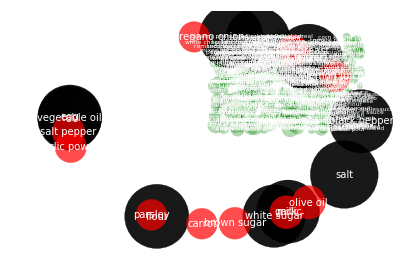

In [32]:
plt.axis('off')

nlist = [x[0] for x in sorted_x[20:]]
ndegree = [x[1] for x in sorted_x[20:]]
pos = nx.random_layout(G)

nx.draw_networkx_nodes(G,pos,nodelist=nlist, node_color="green",with_labels=False,node_size=ndegree, alpha=0.3)
#nx.draw_networkx_nodes(G,pos, node_color="blue",with_labels=True,node_size=[v * 10 for v in d.values()], alpha=0.7)
nx.draw_networkx_labels(G,pos,dict(zip(nlist,nlist)),font_size=6, font_color="white")
nx.draw_networkx_edges(G, pos,nodelist=nlist,edge_color="white");

pos = nx.shell_layout(G)
#nx.draw(G, nodelist=d.keys(), node_size=[v * 100 for v in d.values()])

nlist = [x[0] for x in sorted_x[:10]]
ndegree = [x[1] * 10 for x in sorted_x[:10]]
nx.draw_networkx_nodes(G,pos,nodelist=nlist, node_color="black",with_labels=False,node_size=ndegree, alpha=0.9)
#nx.draw_networkx_nodes(G,pos, node_color="blue",with_labels=True,node_size=[v * 10 for v in d.values()], alpha=0.7)
nx.draw_networkx_labels(G,pos,dict(zip(nlist,nlist)),font_size=10, font_color="white")
nx.draw_networkx_edges(G, pos,nodelist=nlist,edge_color="white");

nlist = [x[0] for x in sorted_x[10:20]]
ndegree = [x[1] * 3 for x in sorted_x[10:20]]

nx.draw_networkx_nodes(G,pos,nodelist=nlist, node_color="red",with_labels=False,node_size=ndegree, alpha=0.7)
#nx.draw_networkx_nodes(G,pos, node_color="blue",with_labels=True,node_size=[v * 10 for v in d.values()], alpha=0.7)
nx.draw_networkx_labels(G,pos,dict(zip(nlist,nlist)),font_size=10, font_color="white")
nx.draw_networkx_edges(G, pos,nodelist=nlist,edge_color="white");

